In [1]:
import numpy as np
import pandas as pd
import pygmt
import os
import time
from datetime import datetime
from pyproj import Geod
from multiprocessing import Pool, cpu_count

# ------------------------ function use in calculation ---------------------------------
def dist2Dsimple(minlong,maxlong,minlat,maxlat):
    '''
    assumed the area is plain, and 1 degree = 111320 m
    '''
    deg_to_m = 111320
    # convert to numeric 
    minlong = np.float64(minlong)
    maxlong = np.float64(maxlong)
    minlat = np.float64(minlat)
    maxlat = np.float64(maxlat)
    #
    dist = np.sqrt(((maxlong - minlong )**2) + ((maxlat - minlat ) **2))* deg_to_m #
    return dist
def dist2d(long1, lat1,long2, lat2):
    from pyproj import Geod
    '''
    calculate the distance of 2 points
    '''
    # Define geodetic system (WGS84)
    geod = Geod(ellps='WGS84')
    _, _, dist = geod.inv(long1, lat1,long2, lat2)
    
    return dist
### ------------------- ###
def area_ha(minlong,maxlong,minlat,maxlat):
    import geopandas as gpd
    from shapely.geometry import Polygon
    # Define a list of (longitude, latitude) coordinates that form the boundary of the study area
    coords = [(minlong, minlat), (minlong, maxlat), (maxlong, maxlat), (maxlong, minlat)] 
    # Create a Polygon from the coordinates
    polygon = Polygon(coords)
    # Create a GeoDataFrame with WGS84 CRS (EPSG:3405)
    gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:6405", geometry=[polygon])
    # Reproject to a UTM projection for area calculation (adjust EPSG based on your location)
    gdf = gdf.to_crs(epsg=3405)  # UTM zone 48N for Vietnam
    # Calculate the area in square meters
    area_sq_meters = gdf.geometry.area[0]
    # Convert square meters to hectares (1 hectare = 10,000 square meters)
    area_hectares = area_sq_meters #/ 10000
    return area_hectares
### ------------------- ###
def area_ha_plain(minlong,minlat,maxlong,maxlat):
    '''
    assumed the area is plain, and 1 degree = 111320 m
    '''
    deg_to_m = 111320
    aream = ((maxlong - minlong ) * deg_to_m) * ((maxlat - minlat ) * deg_to_m) #
    area =  aream/10000 # 1 ha = 10000 meters
    return area
    
### ------------------- ###
def cal_body_cross_section(DBH):
    import numpy as np
    '''
    Calculate the speccy's cross-section diameter follow Curtis & Macintosh 1951
    '''
    DBH = np.float64(DBH)
    #
    G = (3.142 * (DHB**2))/40000
    return G
### ------------------- ###
def density(NoS,area):
    '''
    Calculate the density based on the data frame data (number of speccy over all number of species)
    '''
    #
    NoS = np.int(NoS);
    area = np.float64(area);
    #
    dens = NoS/area;
    #
    return dens
### ------------------- ###
def cal_sp_super():
    '''
    Calculate the species superiority index based on the density and body crosssection
    '''
    return IVI
# -----------------------------------------------------------------------------------------    
def process_pair(args):
    '''
    parallel process the data of the dataframe
    '''
    i, sname, datanow = args
    row_i = datanow.loc[i]
    result = []

    for j in range(len(datanow)):
        if i == j:
            continue

        row_j = datanow.loc[j]

        dist_now = dist2d(row_i['Longitude'], row_i['Latitude'],
                          row_j['Longitude'], row_j['Latitude'])

        result.append([
            row_i['sname'], row_i['Code'], row_i['Longitude'], row_i['Latitude'],
            row_i['d2x'], row_i['d2y'], row_i['C(cm)'], row_i['DBH(cm)'], row_i['S(m2)'], row_i['Code'],
            row_j['sname'], row_j['Code'], row_j['Longitude'], row_j['Latitude'],
            row_j['d2x'], row_j['d2y'], row_j['C(cm)'], row_j['DBH(cm)'], row_j['S(m2)'], row_j['Code'],
            dist_now
        ])

    return result
# ---------------------------------------------------------------------------------------

if __name__ == "__main__":
    while True:
        answer = input("If you run with new data, press yes, else no for skip this step? (yes/no): ").strip().lower()
        if answer in ["yes", "no"]:
            break
        print("Please type yes or no.")

    if answer == "no":
        print("Cancelled.")
    else:
        print("Running code...")
        
        # your code here
        # Start timing
        t0 = time.time()
        start_time_str = datetime.now().strftime("Start time: %a %b %d %H:%M:%S %Y")
        print(start_time_str)
        
        pwd = os.getcwd()
        # output directory already created in step 0
        # read the data and kip 2 rows due to format error
        data = pd.read_csv(os.path.join(pwd,"output","00_intitial_data.txt"), sep=',',
                           # names=["index","jk1","name","lat","long","code"],
                           header=0,
                          )
        data
        # # # Now calculate the area for study area based on the species coordinantes
        cal_min_x=data['Longitude'].min()
        cal_max_x=data['Longitude'].max()
        cal_min_y=data['Latitude'].min()
        cal_max_y=data['Latitude'].max()
        
        # S = area_ha_plain(cal_min_x,cal_max_x,cal_min_y,cal_max_y)
        # # --- > End section Preprocess the dataframe < --- #
        # pre-condition for the data frame
        source=[];  source_code=[]; site_code=[]; source_long=[]; source_lat=[]; source2x=[]; source2y=[];
        soure_C=[]; soure_DBH=[]; soure_S=[]; soure_scode=[];
        site=[]; site_long=[]; site_lat=[]; site2x=[]; site2y=[]; site_C=[]; site_DBH=[]; site_S=[]; site_scode=[];
        distance=[];
        # #
        datanow = data.copy();
        # datanow['sname'] = ['S' + str(i).zfill(4) for i in datanow.index]
        if 'sname' not in datanow.columns:
            datanow['sname'] = ['S' + str(i).zfill(4) for i in datanow.index]
    
        datanow.reset_index(drop=True, inplace=True)
        num_cpus = min(40, cpu_count()) # set minimum CPU run as 40
        print("Starting parallel processing with {} cores...".format(num_cpus))
    
        # Prepare arguments
        args = [(i, datanow.loc[i, 'sname'], datanow) for i in range(len(datanow))]
    
        with Pool(processes=cpu_count()) as pool:
            all_results = pool.map(process_pair, args)
    
        # Flatten list of lists
        flat_results = [item for sublist in all_results for item in sublist]
    
        # Create DataFrame
        columns = ['source', 'source_code', 'source_long', 'source_lat', 'source2x', 'source2y',
                   'source_C', 'source_DBH', 'source_S', 'source_spiccies_code',
                   'site', 'site_code', 'site_long', 'site_lat', 'site2x', 'site2y',
                   'site_C', 'site_DBH', 'site_S', 'site_spiccies_code', 'Dist']
    
        dataout = pd.DataFrame(flat_results, columns=columns)
        print("Write the dataframe to file!")  
        dataout.to_csv(os.path.join(pwd,"output","01_all_distances.txt"),index=False,sep=',',header=True,encoding='utf-8')
        print(' >>>> Export the output file: {}'.format(os.path.join(pwd,"output","01_all_distances.txt")))
        # End timing
        t1 = time.time()
        end_time_str = datetime.now().strftime("End time: %a %b %d %H:%M:%S %Y")  
        total_time = t1 - t0
        print(end_time_str)
        
        print("Total process time: {:.2f} seconds".format(total_time))
        print("Process done!")

If you run with new data, press yes, else no for skip this step? (yes/no):  yes


Running code...
Start time: Thu Dec 04 15:05:17 2025
Starting parallel processing with 40 cores...
Write the dataframe to file!
 >>>> Export the output file: /data/longhv/Projects/VietNga_species_distribution_example/spatial_mapping_v2/output/01_all_distances.txt
End time: Thu Dec 04 15:05:34 2025
Total process time: 16.47 seconds
Process done!


If you want to select data with dominated spices, press yes, else no for skip this step? (yes/no):  yes


Running code...
Start time: Wed Dec 03 21:01:55 2025
Export the bridging file: /data/longhv/Projects/VietNga_species_distribution_example/spatial_mapping_v2/output/01_all_IVI.txt
Export the output file: /data/longhv/Projects/VietNga_species_distribution_example/spatial_mapping_v2/output/01_all_IVI_sorted.txt
Export the figure: /data/longhv/Projects/VietNga_species_distribution_example/spatial_mapping_v2/figures/01.Cumulative_IVI.png


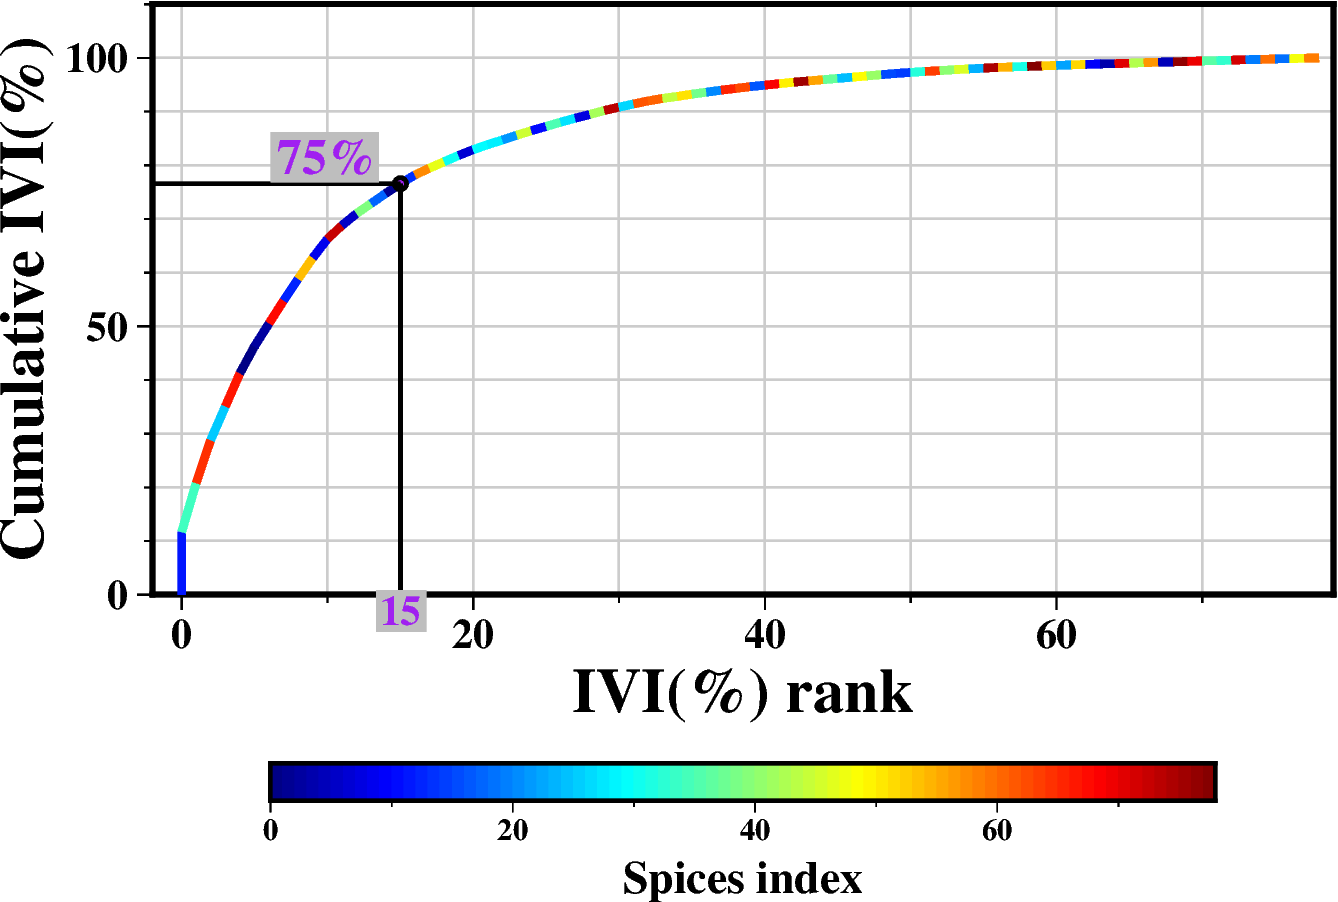

End time: Wed Dec 03 21:01:58 2025
Total process time: 3.32 seconds
Process done!


In [9]:
import numpy as np
import pandas as pd
import pygmt
import os
from multiprocessing import Pool, cpu_count
import time
import sys
from datetime import datetime
# ====================================================================================================================================
'''
Determine the species density, relative frequency (G), and Importance Value Index (IVI) for each type of plant recorded in the dataset.
Output: The cumulate IVI figure and output file: 01_all_IVI_sorted.txt - check this to select the percentage 
'''
# ====================================================================================================================================
def area_ha(minlong, maxlong, minlat, maxlat):
    import geopandas as gpd
    from shapely.geometry import Polygon

    # Create the polygon with 4 input points
    coords = [(minlong, minlat), (minlong, maxlat), 
              (maxlong, maxlat), (maxlong, minlat)]
    polygon = Polygon(coords)

    # create GeoDataFrame with  WGS84 coordinates system
    gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])

    # swich to UTM zone 48N (Vietnam) to calculate the area
    gdf = gdf.to_crs(epsg=3405)  # EPSG:3405 is VN-2000 / UTM zone 48N

    # Area as squared-metter
    area_sq_meters = gdf.geometry.area.iloc[0]

    # Convert to ha (1 ha = 10,000 m2)
    area_hectares = area_sq_meters / 10000

    return area_hectares
    
def area(minlong, maxlong, minlat, maxlat):
    import geopandas as gpd
    from shapely.geometry import Polygon

    # Create the polygon with 4 input points
    coords = [(minlong, minlat), (minlong, maxlat), 
              (maxlong, maxlat), (maxlong, minlat)]
    polygon = Polygon(coords)

    # create GeoDataFrame with  WGS84 coordinates system
    gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])

    # swich to UTM zone 48N (Vietnam) to calculate the area
    gdf = gdf.to_crs(epsg=3405)  # EPSG:3405 là VN-2000 / UTM zone 48N

    # Area as squared-metter
    area_sq_meters = gdf.geometry.area.iloc[0]

    # Convert to ha (1 ha = 10,000 m2)
    area = area_sq_meters

    return area
# ====================================================================================================================================
while True:
    answer = input("If you want to select data with dominated spices, press yes, else no for skip this step? (yes/no): ").strip().lower()
    if answer in ["yes", "no"]:
        break
    print("Please type yes or no.")

if answer == "no":
    print("Cancelled.")
else:
    print("Running code...")
    
    pwd = os.getcwd()
    #
    infile = os.path.join(pwd,"output","01_all_distances.txt")
    #
    if not os.path.isfile(infile):
        raise FileNotFoundError("Required file not found: {}".format(infile))
    data = pd.read_csv(infile,sep=",",header=0)
    # Calculate the S and total density
    xmin = data['source_long'].min();
    xmax = data['source_long'].max();
    ymin = data['source_lat'].min();
    ymax = data['source_lat'].max();
    # the area of the quarant
    S = area_ha(xmin,xmax,ymin,ymax)
    # the area of the quarant
    Sm = area(xmin,xmax,ymin,ymax)
    # speicy density
    denall = len(data['source'].unique())/S; # equal to 100% density
    # total DBH
    DBH_all = (data.groupby('source', as_index=False)['source_DBH'].first())['source_DBH'].sum();
    # stem cross-sectional area (G)
    data['G'] = (np.pi * data['source_DBH']*data['source_DBH'])/200**2
    # Total G
    G_all = (data.groupby('source', as_index=False)['G'].first())['G'].sum();
    # pre-condition the data
    sourcecode = [];
    N = [];
    rel_N = [];
    rel_G = [];
    rel_IVI = [];
    source_codes = [];
    sourcelong = [];
    sourcelat = [];
    Area = [];
    
    # Start timing
    t0 = time.time()
    start_time_str = datetime.now().strftime("Start time: %a %b %d %H:%M:%S %Y")
    print(start_time_str)
    
    for i,scode in enumerate(data['source_code'].unique()):
    # for i,scode in enumerate(['A1']):
        datanow=data[data['source_code'] == scode]; datanow.reset_index(drop=True,inplace=True)
        Nnow = len(datanow['source'].unique())/S # current density
        rel_Nnow = (Nnow/denall)*100 # relative density now
        rel_Gnow = ((datanow.groupby('source', as_index=False)['G'].first())['G'].sum()/G_all)*100 # relative G
        rel_IVInow = (rel_Nnow + rel_Gnow)/2
        # print(i,scode)
        # print(Nnow,rel_Nnow,rel_Gnow,rel_IVInow)
        # append the data
        sourcecode = np.append(sourcecode,scode);
        N = np.append(N,Nnow);
        Area = np.append(Area,Sm);
        rel_N = np.append(rel_N,rel_Nnow);
        rel_G = np.append(rel_G,rel_Gnow);
        rel_IVI = np.append(rel_IVI,rel_IVInow);
        sourcelong = np.append(sourcelong,datanow['source_long'][i]);
        sourcelat = np.append(sourcelat,datanow['source_lat'][i]);
    dataIVI = pd.DataFrame({
        'sourcecode' : sourcecode,
        'sourcelong' : sourcelong,
        'sourcelat' : sourcelat,
        'Area' : Area,
        'N' : N,
        'N%' : rel_N,
        'G%' : rel_G,
        'IVI%' : rel_IVI
    })
    dataIVI.to_csv(os.path.join(pwd,"output","01_all_IVI.txt"),index=False,sep=',',header=True,encoding='utf-8')
    print("Export the bridging file: {}".format(os.path.join(pwd,"output","01_all_IVI.txt")))
    dataIVI_sorted = dataIVI.sort_values(by='IVI%', ascending=False)
    dataIVI_sorted['IVIcu'] = dataIVI_sorted['IVI%'].cumsum()
    dataIVI_sorted['idx']=dataIVI_sorted.index
    dataIVI_sorted.reset_index(drop=True,inplace=True)
    dataIVI_sorted['index'] = dataIVI_sorted.index  # explicitly add it as a column
    dataIVI_sorted.to_csv(os.path.join(pwd,"output","01_all_IVI_sorted.txt"),index=False,sep=',',header=True,encoding='utf-8')
    print("Export the output file: {}".format(os.path.join(pwd,"output","01_all_IVI_sorted.txt")))
    
    #
    # find the point of IVIcu >= 75%
    target_value = 75
    mask_75 = dataIVI_sorted['IVIcu'] >= target_value
    idx_75 = mask_75.idxmax()  # chỉ số hàng trong dataframe
    
    # take the x and y axis
    x_75 = dataIVI_sorted.loc[idx_75, 'index']
    y_75 = dataIVI_sorted.loc[idx_75, 'IVIcu']
    
    # Plot the figure
    fig = pygmt.Figure()
    # Config the figure 
    pygmt.config(FONT_LABEL="15p,Times-Bold,black")
    pygmt.config(FONT_TITLE="15p,Times-Bold,black")
    pygmt.config(FONT_ANNOT_PRIMARY="10p,Times-Bold,black")
    pygmt.config(FONT_ANNOT_SECONDARY="10p,Times-Roman,black")
    pygmt.config(MAP_FRAME_TYPE="fancy")
    pygmt.config(FORMAT_GEO_MAP="ddd.xxF")
    pygmt.config(MAP_GRID_PEN_PRIMARY="0.5p,gray80")
    
    # pygmt.makecpt(cmap="viridis", series=[dataIVI_sorted.idx.min(), dataIVI_sorted.idx.max()])
    pygmt.makecpt(cmap="jet", series=[0, int(dataIVI_sorted.idx.max()), 1], color_model="+c0-{}".format(int(dataIVI_sorted.idx.max())))
    # Set region and projection
    fig.basemap(
        region=[-2, len(dataIVI_sorted), 0, 110],
        projection="X10c/5c",
        frame=["yafg10+lCumulative IVI(%)", 'xafg10+l"IVI(%) rank"']
    )
    
    plot_data = dataIVI_sorted[['index', 'IVIcu', 'idx']]  # x, y, intensity (z)
    # Fill under the curve
    for i,z in enumerate(dataIVI_sorted['idx']):
        if i == 0:
            x = [0, dataIVI_sorted['index'][0]]
            y = [0, dataIVI_sorted['IVIcu'][0]]
        else:
            x=dataIVI_sorted['index'][i-1:i+1];
            y=dataIVI_sorted['IVIcu'][i-1:i+1];
        # print(x,y,z)
        fig.plot(x=x, y=y, cmap=True, zvalue=z, pen="2p,+z,-")
    # The IVI 75% point
    fig.plot(x=[x_75], y=[y_75], style="c0.1c", fill="purple", pen="1p,black")
    # project to y axis
    fig.plot(x=[x_75, x_75], y=[-100, y_75], pen="1p,black")
    # project to x axis
    fig.plot(x=[-100, x_75], y=[y_75, y_75], pen="1p,black")
    # text label
    fig.text(x=x_75-5, y=y_75 + 5, text="75%", font="12p,Times-Bold,purple", angle=0,
             fill='gray',
             # ,box="+gwhite+p1p,black+gred+r"
            )
    # # text on y
    # fig.text(x=-2, y=y_75, text="{}".format(int(y_75)), font="10p,Times-Bold,purple", angle=0,
    #          fill='gray', no_clip=True,
    #         )
    # text on x
    fig.text(x=x_75, y=-3, text="{}".format(x_75), font="10p,Times-Bold,purple", angle=0,
             fill='gray', no_clip=True,
             # ,box="+gwhite+p1p,black+gred+r"
            )
    
    
    pygmt.makecpt(cmap="jet", series=[0, int(dataIVI_sorted.idx.max()), 1])
    fig.colorbar(frame='af+l"Spices index"')
    fig.savefig(os.path.join(pwd,"figures","01.Cumulative_IVI.png"),crop=True, dpi=500, transparent=False)
    print("Export the figure: {}".format(os.path.join(pwd,"figures","01.Cumulative_IVI.png")))
    fig.show()
    # End timing
    t1 = time.time()
    end_time_str = datetime.now().strftime("End time: %a %b %d %H:%M:%S %Y")  
    total_time = t1 - t0
    print(end_time_str)
    
    print("Total process time: {:.2f} seconds".format(total_time))
    print("Process done!") 

In [12]:
len(data['source_code'].unique())

79

Select the data for 2 - spices, press yes, else no for skip this step? (yes/no):  yes


Running code...


The 1st species code (e.g. A11):  A42
The 2nd species code (e.g. A21):  A72


Dacrydium elatum  Syzygium zeylanicum
Start time: Thu Dec 04 15:56:03 2025
Export the bridging file: /data/longhv/Projects/VietNga_species_distribution_example/spatial_mapping_v2/output/01_all_IVI.txt
Export the output file: /data/longhv/Projects/VietNga_species_distribution_example/spatial_mapping_v2/output/01_all_IVI_sorted.txt
Export the figure: /data/longhv/Projects/VietNga_species_distribution_example/spatial_mapping_v2/figures/01.Cumulative_IVI.png


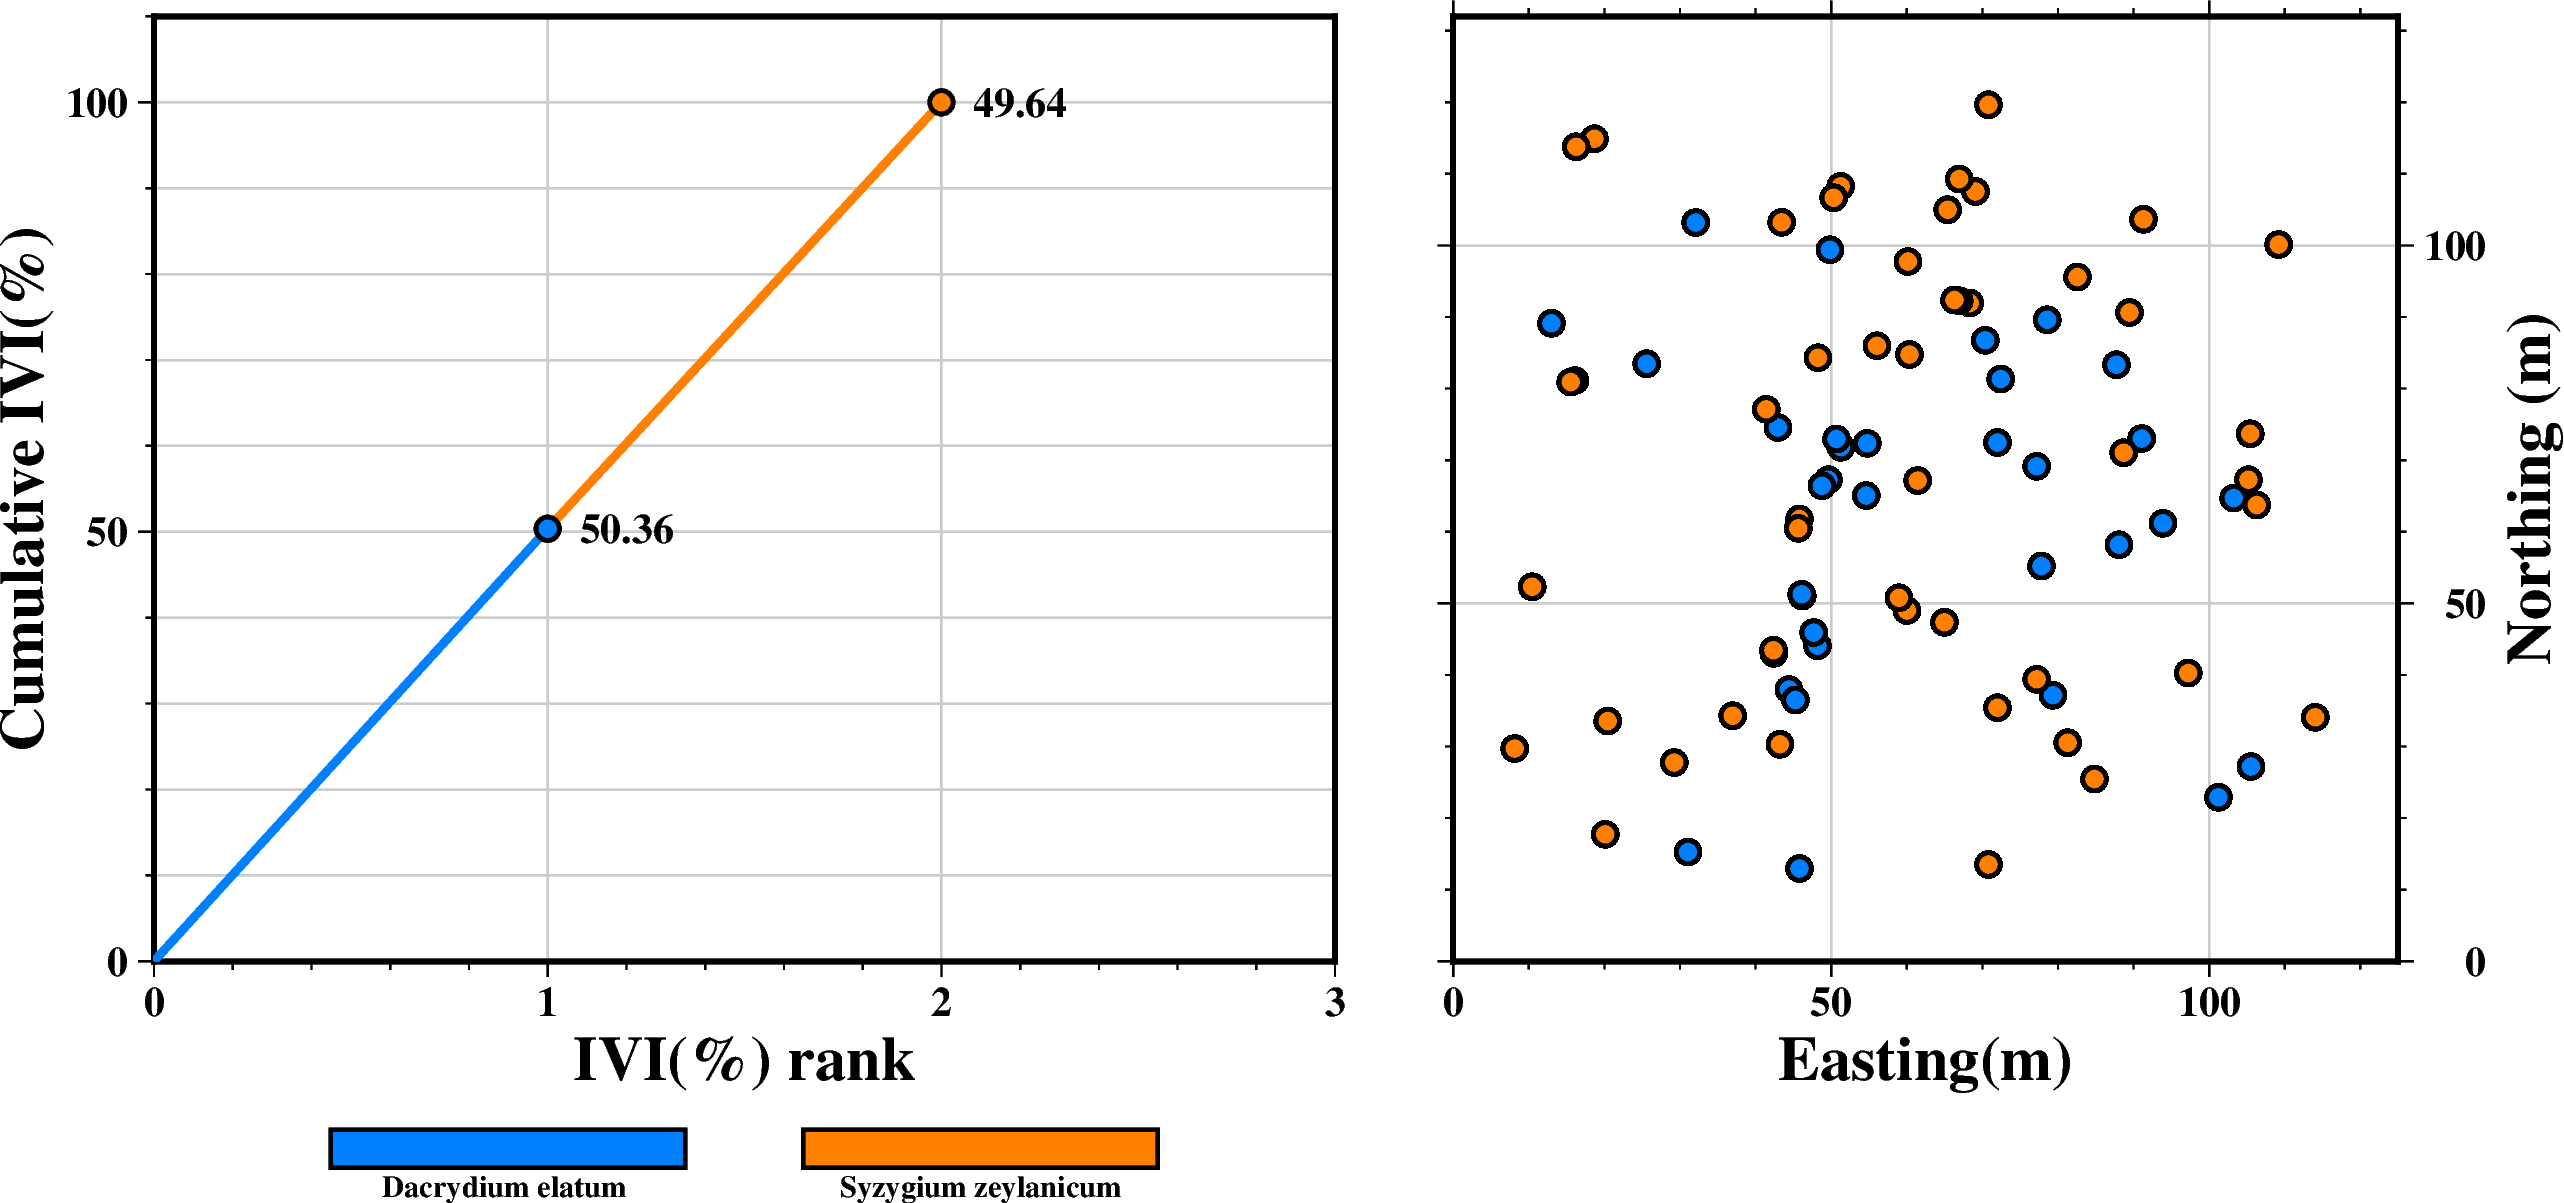

End time: Thu Dec 04 15:56:05 2025
Total process time: 1.63 seconds
Process done!


In [1]:
import numpy as np
import pandas as pd
import pygmt
import os
from multiprocessing import Pool, cpu_count
import time
import sys
from datetime import datetime
# ====================================================================================================================================
'''
Determine the species density, relative frequency (G), and Importance Value Index (IVI) for each type of plant recorded in the dataset.
Select the output data based on spices index [for 2 spices]
Output: 
'''
# ====================================================================================================================================
def area_ha(minlong, maxlong, minlat, maxlat):
    import geopandas as gpd
    from shapely.geometry import Polygon

    # Create the polygon with 4 input points
    coords = [(minlong, minlat), (minlong, maxlat), 
              (maxlong, maxlat), (maxlong, minlat)]
    polygon = Polygon(coords)

    # create GeoDataFrame with  WGS84 coordinates system
    gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])

    # swich to UTM zone 48N (Vietnam) to calculate the area
    gdf = gdf.to_crs(epsg=3405)  # EPSG:3405 is VN-2000 / UTM zone 48N

    # Area as squared-metter
    area_sq_meters = gdf.geometry.area.iloc[0]

    # Convert to ha (1 ha = 10,000 m2)
    area_hectares = area_sq_meters / 10000

    return area_hectares
    
def area(minlong, maxlong, minlat, maxlat):
    import geopandas as gpd
    from shapely.geometry import Polygon

    # Create the polygon with 4 input points
    coords = [(minlong, minlat), (minlong, maxlat), 
              (maxlong, maxlat), (maxlong, minlat)]
    polygon = Polygon(coords)

    # create GeoDataFrame with  WGS84 coordinates system
    gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])

    # swich to UTM zone 48N (Vietnam) to calculate the area
    gdf = gdf.to_crs(epsg=3405)  # EPSG:3405 là VN-2000 / UTM zone 48N

    # Area as squared-metter
    area_sq_meters = gdf.geometry.area.iloc[0]

    # Convert to ha (1 ha = 10,000 m2)
    area = area_sq_meters

    return area
import re

def ask_code(text):
    while True:
        code = input(text).strip().upper()
        if re.fullmatch(r"[A-Z]\d{2}", code):
            return code
        print("Invalid format! Must be like A11, B03, C27.")

def get_name(file,A1,A2):
    data_name = pd.read_csv(file,sep=",",header=0)
    # Now get name of A1 and A2
    name_A1 = data_name.loc[data_name['Code'] == A1, 'Nomenclature'].iloc[0]
    name_A2 = data_name.loc[data_name['Code'] == A2, 'Nomenclature'].iloc[0]
    return name_A1,name_A2
# ====================================================================================================================================
while True:
    answer = input("Select the data for 2 - spices, press yes, else no for skip this step? (yes/no): ").strip().lower()
    if answer in ["yes", "no"]:
        break
    print("Please type yes or no.")

if answer == "no":
    print("Cancelled.")
else:
    print("Running code...")
    A1 = ask_code("The 1st species code (e.g. A11): ")
    A2 = ask_code("The 2nd species code (e.g. A21): ")

    pwd = os.getcwd()
    #
    inifile = os.path.join(pwd,"output","00_intitial_data.txt")
    infile = os.path.join(pwd,"output","01_all_distances.txt")

    name1, name2 = get_name(inifile,A1,A2)
    print(name1,name2)
    #
    if not os.path.isfile(infile):
        raise FileNotFoundError("Required file not found: {}".format(infile))
    data = pd.read_csv(infile,sep=",",header=0)
    # Calculate the S and total density
    xmin = data['source_long'].min();
    xmax = data['source_long'].max();
    ymin = data['source_lat'].min();
    ymax = data['source_lat'].max();
    # Filter the data here
    data = data[(data['source_code'].isin([A1, A2])) & (data['site_code'].isin([A1, A2]))]
    data.reset_index(drop=True,inplace=True)
    data_copy = data.copy;
    #
    code_to_name = {A1: name1, A2: name2}
    data['Nomenclature'] = data['source_code'].map(code_to_name)
    # Each species name -> a category -> numeric code (0,1,2,...)
    cats = data['source_code'].astype('category')
    data['sp_id'] = cats.cat.codes        # 0, 1 for two species
    species_names = list(cats.cat.categories)   # e.g. [name1, name2]
    
    # the area of the quarant
    S = area_ha(xmin,xmax,ymin,ymax)
    # the area of the quarant
    Sm = area(xmin,xmax,ymin,ymax)
    # speicy density
    denall = len(data['source'].unique())/S; # equal to 100% density
    # total DBH
    DBH_all = (data.groupby('source', as_index=False)['source_DBH'].first())['source_DBH'].sum();
    # stem cross-sectional area (G)
    data['G'] = (np.pi * data['source_DBH']*data['source_DBH'])/200**2
    # Total G
    G_all = (data.groupby('source', as_index=False)['G'].first())['G'].sum();
    # pre-condition the data
    sourcecode = [];
    N = [];
    rel_N = [];
    rel_G = [];
    rel_IVI = [];
    source_codes = [];
    sourcelong = [];
    sourcelat = [];
    Area = [];
    Nom = [];
    
    # Start timing
    t0 = time.time()
    start_time_str = datetime.now().strftime("Start time: %a %b %d %H:%M:%S %Y")
    print(start_time_str)
    
    for i,scode in enumerate(data['source_code'].unique()):
    # for i,scode in enumerate(['A1']):
        datanow=data[data['source_code'] == scode]; datanow.reset_index(drop=True,inplace=True)
        Nnow = len(datanow['source'].unique())/S # current density
        rel_Nnow = (Nnow/denall)*100 # relative density now
        rel_Gnow = ((datanow.groupby('source', as_index=False)['G'].first())['G'].sum()/G_all)*100 # relative G
        rel_IVInow = (rel_Nnow + rel_Gnow)/2
        # print(i,scode)
        # print(Nnow,rel_Nnow,rel_Gnow,rel_IVInow)
        # append the data
        sourcecode = np.append(sourcecode,scode);
        N = np.append(N,Nnow);
        Area = np.append(Area,Sm);
        rel_N = np.append(rel_N,rel_Nnow);
        rel_G = np.append(rel_G,rel_Gnow);
        rel_IVI = np.append(rel_IVI,rel_IVInow);
        sourcelong = np.append(sourcelong,datanow['source_long'][i]);
        sourcelat = np.append(sourcelat,datanow['source_lat'][i]);
        # correct Nomenclature: either from datanow or from code_to_name
        Nom = np.append(Nom, datanow['Nomenclature'].iloc[0])
    dataIVI = pd.DataFrame({
        'sourcecode' : sourcecode,
        'sourcelong' : sourcelong,
        'sourcelat' : sourcelat,
        'Area' : Area,
        'N' : N,
        'N%' : rel_N,
        'G%' : rel_G,
        'IVI%' : rel_IVI,
        'Nomenclature' : Nom,
    })
    dataIVI.to_csv(os.path.join(pwd,"output","01_all_IVI.txt"),index=False,sep=',',header=True,encoding='utf-8')
    print("Export the bridging file: {}".format(os.path.join(pwd,"output","01_all_IVI.txt")))
    dataIVI_sorted = dataIVI.sort_values(by='IVI%', ascending=False)
    dataIVI_sorted['IVIcu'] = dataIVI_sorted['IVI%'].cumsum()
    dataIVI_sorted['idx']=dataIVI_sorted.index
    dataIVI_sorted.reset_index(drop=True,inplace=True)
    dataIVI_sorted['index'] = dataIVI_sorted.index  # explicitly add it as a column
    dataIVI_sorted.to_csv(os.path.join(pwd,"output","01_all_IVI_sorted.txt"),index=False,sep=',',header=True,encoding='utf-8')
    print("Export the output file: {}".format(os.path.join(pwd,"output","01_all_IVI_sorted.txt")))
    
    #
    # find the point of IVIcu >= 75%
    target_value = 90 # 2 spices then all >90%
    mask_75 = dataIVI_sorted['IVIcu'] >= target_value
    idx_75 = mask_75.idxmax()  # chỉ số hàng trong dataframe
    
    # take the x and y axis
    x_75 = dataIVI_sorted.loc[idx_75, 'index']
    y_75 = dataIVI_sorted.loc[idx_75, 'IVIcu']
    
    # Plot the figure
    fig = pygmt.Figure()
    # Config the figure 
    pygmt.config(FONT_LABEL="15p,Times-Bold,black")
    pygmt.config(FONT_TITLE="15p,Times-Bold,black")
    pygmt.config(FONT_ANNOT_PRIMARY="10p,Times-Bold,black")
    pygmt.config(FONT_ANNOT_SECONDARY="10p,Times-Roman,black")
    pygmt.config(MAP_FRAME_TYPE="fancy")
    pygmt.config(FORMAT_GEO_MAP="ddd.xxF")
    pygmt.config(MAP_GRID_PEN_PRIMARY="0.5p,gray80")
    
    # pygmt.makecpt(cmap="viridis", series=[dataIVI_sorted.idx.min(), dataIVI_sorted.idx.max()])
    pygmt.makecpt(cmap="jet", series=[0, 1, 1], 
                  # color_model="+c0-{}".format(int(dataIVI_sorted.idx.max()))
                  color_model="+c{},{}".format(name1,name2)
                 )
    # Set region and projection
    fig.basemap(
        region=[0, len(dataIVI_sorted)+1, 0, 110],
        projection="X10c/8c",
        frame=["yafg10+lCumulative IVI(%)", 'xa1fg1+l"IVI(%) rank"']
    )
    
    plot_data = dataIVI_sorted[['index', 'IVIcu', 'idx']]  # x, y, intensity (z)
    # Fill under the curve
    for i,z in enumerate(dataIVI_sorted['idx']):
        if i == 0:
            x = [0, 1]
            y = [0, dataIVI_sorted['IVIcu'][0]]
        else:
            x=[1,2];
            y=dataIVI_sorted['IVIcu'][i-1:i+1];
        # print(x,y,z)
        fig.plot(x=x, y=y, cmap=True, zvalue=z, pen="2p,+z,-")
    
    fig.plot(x=dataIVI_sorted['index']+1, y=dataIVI_sorted['IVIcu'], style="c0.2c",cmap=True, fill=dataIVI_sorted['idx'],pen="1p,black")
    fig.text(x=dataIVI_sorted['index']+1.2, y=dataIVI_sorted['IVIcu'], text=dataIVI_sorted['IVI%'].round(2))
    
    fig.colorbar(
    cmap=True,              # use the CPT we just defined
    # frame=['x+l"Species"', 'y+ln'],  # label the bar; y+ln = generic “n”
    equalsize=1             # equal-sized boxes for the two categories
    )
    # ---------------------------- maping the categorical data ---------------------------------------------
    fig.shift_origin(xshift="w+3c")
    nsp = len(species_names)
    pygmt.makecpt(
        cmap="jet",                      # or another cmap
        series=[0, nsp - 1, 1],          # 0..nsp-1, step 1
        color_model="+c" + ",".join(species_names)
    )
    fig.basemap(
        # region=[0, np.maximum(data['source2x'].max(),data['site2x'].max()).round(0), 0, np.maximum(data['source2y'].max(),data['site2y'].max()).round(0)],
        region=[0, (data['source2x'].max()*1.1).round(0), 0, (1.1*data['source2y'].max()).round(0)],
        projection="X8c/8c",
        frame=["nSwE","yafg+lNorthing (m)", 'xafg+l"Easting(m)"']
    )
    fig.plot(x=data['source2x'], y=data['source2y'], style="c0.2c",cmap=True, fill=data['sp_id'],pen="1p,black")
    
    fig.savefig(os.path.join(pwd,"figures","01.Cumulative_IVI.png"),crop=True, dpi=500, transparent=False)
    print("Export the figure: {}".format(os.path.join(pwd,"figures","01.Cumulative_IVI.png")))
    fig.show()
    # End timing
    t1 = time.time()
    end_time_str = datetime.now().strftime("End time: %a %b %d %H:%M:%S %Y")  
    total_time = t1 - t0
    print(end_time_str)
    print("Total process time: {:.2f} seconds".format(total_time))
    print("Process done!") 
